# Unified MCTS Demonstration

This notebook demonstrates the unified MCTS implementation with all four variants:
- **Basic MCTS**: Standard MCTS without priority or parallelization
- **Priority MCTS**: MCTS with priority-guided rollouts
- **Parallel MCTS**: Multi-threaded MCTS with virtual loss
- **Advanced MCTS**: Combined priority + parallel + annealing

You can easily switch between environments and MCTS methods for experiments.

## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Dict, Any

# Import the unified MCTS and environment registry
from src.algos.mcts_unified import UnifiedMCTS, N3ilUnified, SupNormPriority, evaluate_unified
from src.registry.env_registry import get_env
try:
    from src.registry.algo_registry import get_algo
    REGISTRY_AVAILABLE = True
    print("Registry import successful!")
except ImportError as e:
    print(f"Registry import failed: {e}")
    print("Will use direct instantiation instead.")
    REGISTRY_AVAILABLE = False

from src.envs import NoThreeCollinearEnvWithPriority, Point

print("Setup complete!")

Registry import successful!
Setup complete!


## Configuration

Customize your experiment by selecting the environment and MCTS variant:

In [ ]:
# ============= EXPERIMENT CONFIGURATION =============

# Environment settings
GRID_SIZE = 60  # Size of the grid (n x n) - Updated to 60x60
ENV_NAME = "NoThreeCollinearEnvWithPriority"  # Environment type

# MCTS variant selection (choose one):
MCTS_VARIANT = "basic"      # Standard MCTS
# MCTS_VARIANT = "priority"   # Priority-guided MCTS
# MCTS_VARIANT = "parallel"   # Parallel MCTS
# MCTS_VARIANT = "advanced"   # All features combined

# MCTS hyperparameters
MCTS_CONFIG = {
    'n': GRID_SIZE,
    'num_searches': 1000,      # Number of MCTS simulations
    'C': 1.414,                # UCB exploration constant
    'top_n': 2,                # Top N priority levels (for priority variants)
    'num_workers': 4,          # Number of parallel workers (for parallel variants)
    'virtual_loss': 1.0,       # Virtual loss value (for parallel variants)
    'priority_type': 'supnorm', # Priority system type
    'display_state': False,    # Show game states during play (disabled for 60x60)
    'process_bar': False,      # Show progress bar during MCTS search
    'use_annealing': False,    # Use simulated annealing (auto-set by variant)
    'simulate_with_priority': False  # Use priority rollouts (auto-set by variant)
}

print(f"Configuration:")
print(f"  Environment: {ENV_NAME} ({GRID_SIZE}x{GRID_SIZE})")
print(f"  MCTS Variant: {MCTS_VARIANT}")
print(f"  Simulations: {MCTS_CONFIG['num_searches']}")
if MCTS_VARIANT in ['priority', 'advanced']:
    print(f"  Priority Top-N: {MCTS_CONFIG['top_n']}")
if MCTS_VARIANT in ['parallel', 'advanced']:
    print(f"  Parallel Workers: {MCTS_CONFIG['num_workers']}")

Configuration:
  Environment: NoThreeCollinearEnvWithPriority (5x5)
  MCTS Variant: basic
  Simulations: 1000


## Priority Function Definition

Define the priority function for the environment (used by priority-based variants):

Priority function defined!


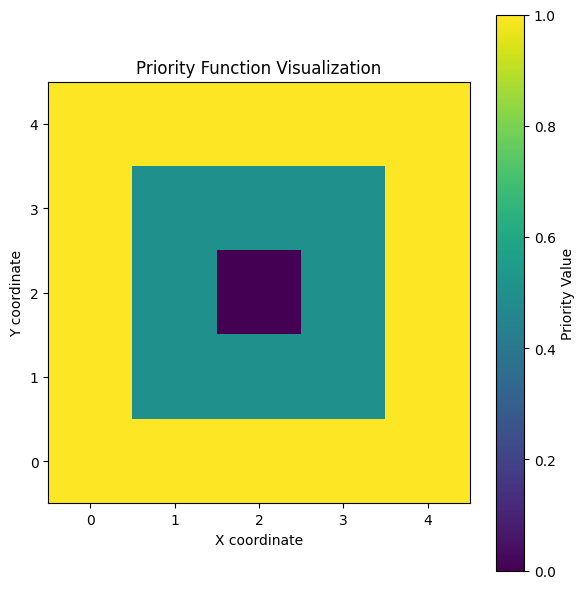

In [3]:
def priority_function(p: Point, grid_size) -> float:
    """Priority function: higher values for positions closer to corners/edges."""
    x, y = p.x, p.y
    m, n = grid_size
    # Sup-norm priority (distance from center)
    center_x, center_y = (m - 1) / 2, (n - 1) / 2
    return max(abs(x - center_x), abs(y - center_y)) / max(center_x, center_y)

print("Priority function defined!")

# Visualize the priority function
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
priority_grid = np.zeros((GRID_SIZE, GRID_SIZE))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        priority_grid[i, j] = priority_function(Point(i, j), (GRID_SIZE, GRID_SIZE))

im = ax.imshow(priority_grid, cmap='viridis', origin='lower')
ax.set_title('Priority Function Visualization')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
plt.colorbar(im, ax=ax, label='Priority Value')
plt.tight_layout()
plt.show()

## Environment Setup

Create the environment instance with the selected configuration:

Environment created: 5x5 No-Three-Collinear with priority function
Maximum theoretical points: ~10

Empty environment:


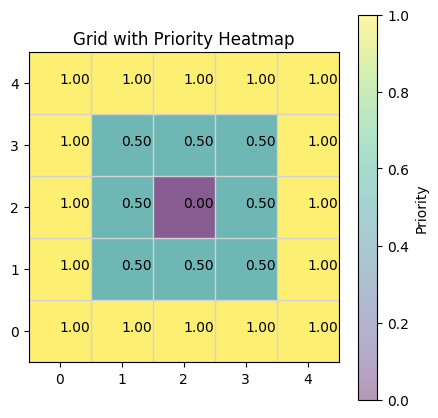

In [4]:
# Create environment instance
env = NoThreeCollinearEnvWithPriority(GRID_SIZE, GRID_SIZE, priority_function)

print(f"Environment created: {GRID_SIZE}x{GRID_SIZE} No-Three-Collinear with priority function")
print(f"Maximum theoretical points: ~{GRID_SIZE * 2}")

# Show empty environment
env.reset()
print("\nEmpty environment:")
env.plot()

## MCTS Algorithm Setup

Initialize the MCTS algorithm with the selected variant:

In [5]:
# Create unified MCTS environment first
unified_env = N3ilUnified(
    grid_size=(GRID_SIZE, GRID_SIZE), 
    args=MCTS_CONFIG, 
    priority_system=SupNormPriority()
)

# Try to get MCTS algorithm from registry, fallback to direct instantiation
mcts = None

if REGISTRY_AVAILABLE:
    try:
        mcts_constructor = get_algo(f'mcts_{MCTS_VARIANT}')
        # The registry returns a lambda that creates the MCTS instance
        mcts = mcts_constructor(MCTS_CONFIG, env=None, logger=None)
        print(f"✓ Loaded MCTS variant from registry: {MCTS_VARIANT}")
    except Exception as e:
        print(f"Registry failed: {e}")
        mcts = None

# Fallback to direct instantiation if registry failed
if mcts is None:
    print("Using direct UnifiedMCTS instantiation...")
    mcts = UnifiedMCTS(unified_env, MCTS_CONFIG, variant=MCTS_VARIANT)
    print(f"✓ Direct MCTS setup complete: {MCTS_VARIANT}")

print(f"\nMCTS Configuration for '{MCTS_VARIANT}' variant:")
if hasattr(mcts, 'args'):
    relevant_keys = ['simulate_with_priority', 'use_annealing', 'num_workers']
    for key in relevant_keys:
        if key in mcts.args:
            print(f"  {key}: {mcts.args[key]}")
elif hasattr(mcts, 'config'):  # Check alternate config attribute
    relevant_keys = ['simulate_with_priority', 'use_annealing', 'num_workers']
    for key in relevant_keys:
        if key in mcts.config:
            print(f"  {key}: {mcts.config[key]}")
            
print(f"  MCTS type: {type(mcts).__name__}")
print(f"  Environment type: {type(unified_env).__name__}")

✓ Loaded MCTS variant from registry: basic

MCTS Configuration for 'basic' variant:
  simulate_with_priority: False
  use_annealing: False
  num_workers: 1
  MCTS type: UnifiedMCTS
  Environment type: N3ilUnified


## Single Game Demonstration

Play a complete game using the selected MCTS variant:

Playing a complete game with basic MCTS...

Move 1: Running MCTS (1000 simulations)...
  Selected action: (1, 4) [prob: 0.155, time: 0.03s]


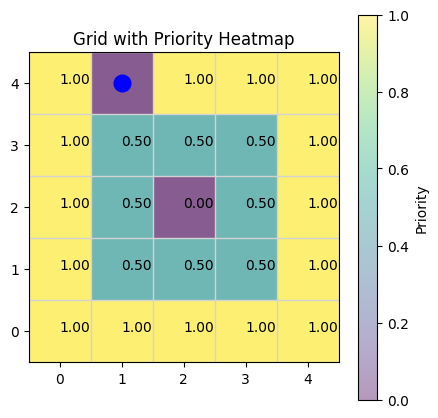

  Current state (after 1 moves):


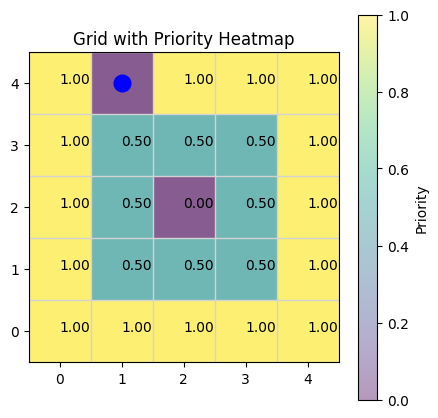


Move 2: Running MCTS (1000 simulations)...
  Selected action: (1, 3) [prob: 0.186, time: 0.02s]


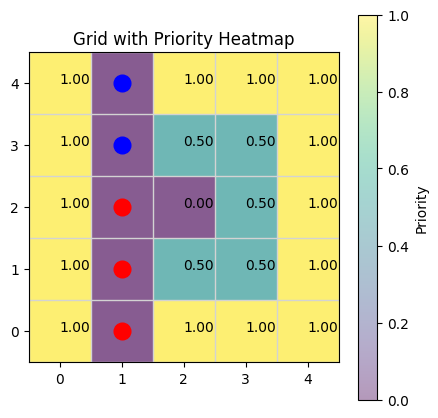

  Current state (after 2 moves):


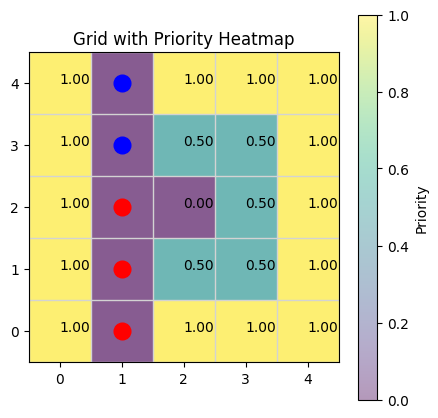


Move 3: Running MCTS (1000 simulations)...
  Selected action: (3, 0) [prob: 0.302, time: 0.01s]


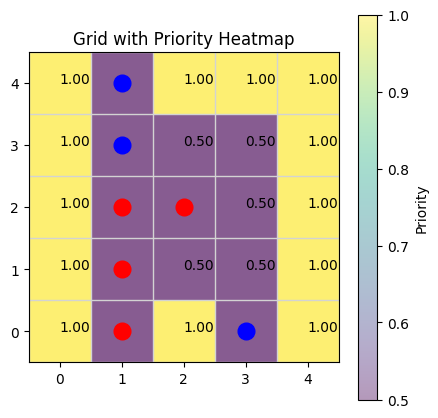

  Current state (after 3 moves):


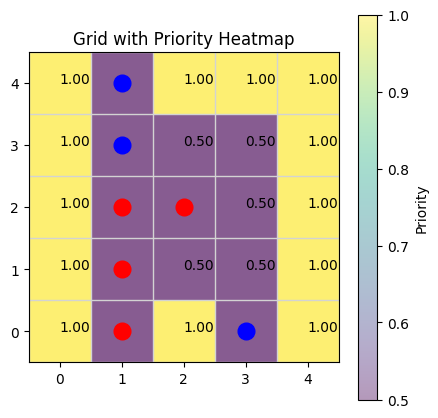


Move 4: Running MCTS (1000 simulations)...
  Selected action: (2, 4) [prob: 0.231, time: 0.01s]


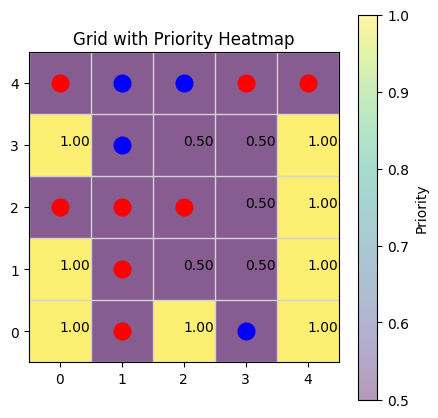

  Current state (after 4 moves):


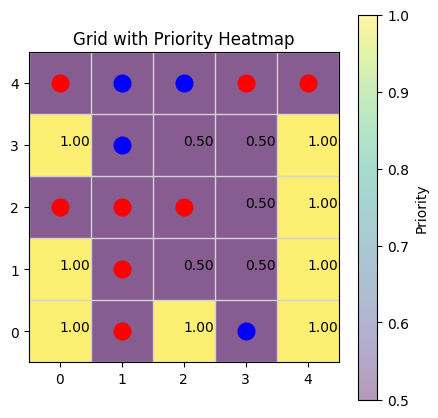


Move 5: Running MCTS (1000 simulations)...
  Selected action: (3, 1) [prob: 0.718, time: 0.01s]


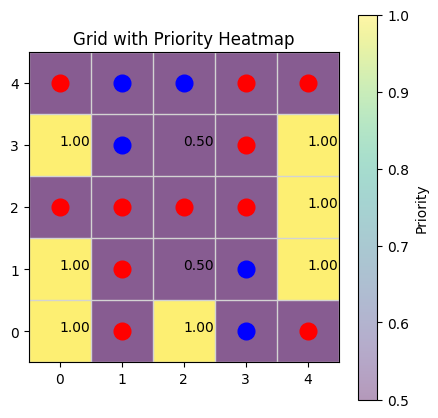

  Current state (after 5 moves):


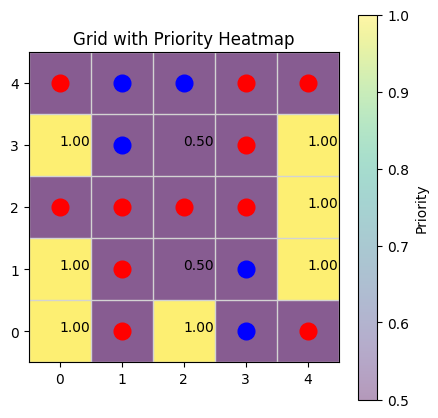


Move 6: Running MCTS (1000 simulations)...
  Selected action: (0, 3) [prob: 0.801, time: 0.00s]


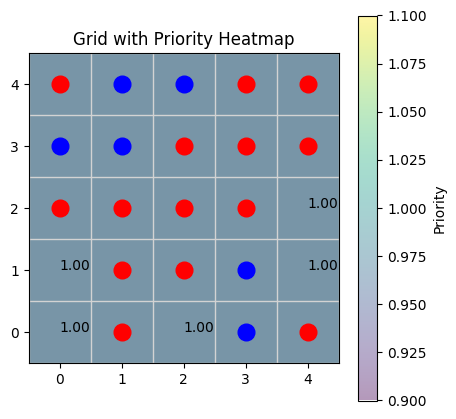

  Current state (after 6 moves):


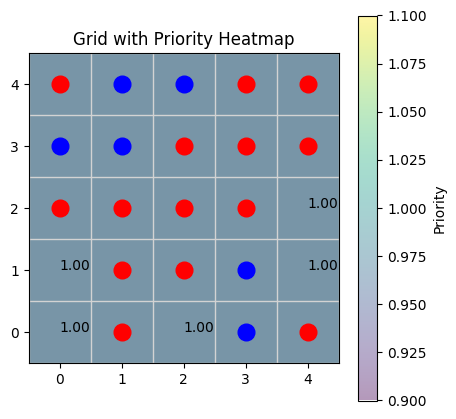


Move 7: Running MCTS (1000 simulations)...
  Selected action: (4, 1) [prob: 0.896, time: 0.00s]


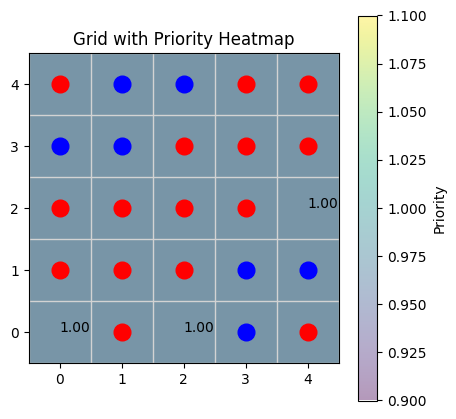

  Current state (after 7 moves):


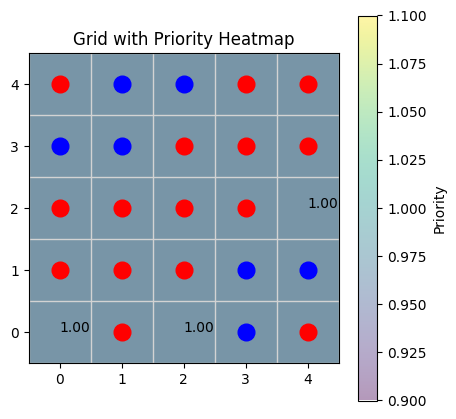


Move 8: Running MCTS (1000 simulations)...
  Selected action: (4, 2) [prob: 0.502, time: 0.00s]


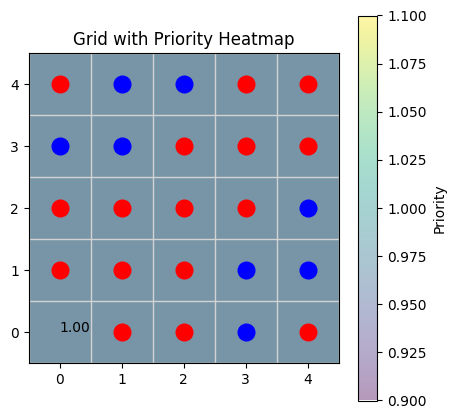

  Current state (after 8 moves):


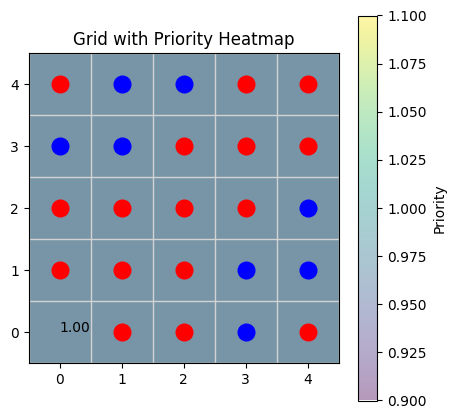


Move 9: Running MCTS (1000 simulations)...
  Selected action: (0, 0) [prob: 1.000, time: 0.00s]


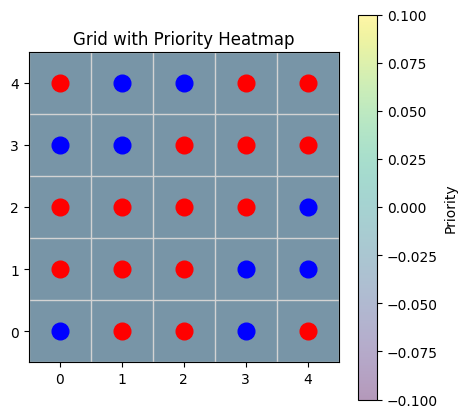

  Current state (after 9 moves):


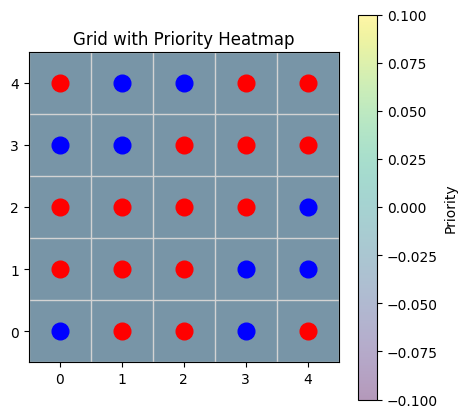


Game completed!
Final result: 9 points in 9 moves
Total time: 1.14 seconds
Average time per move: 0.13 seconds

Final game state:


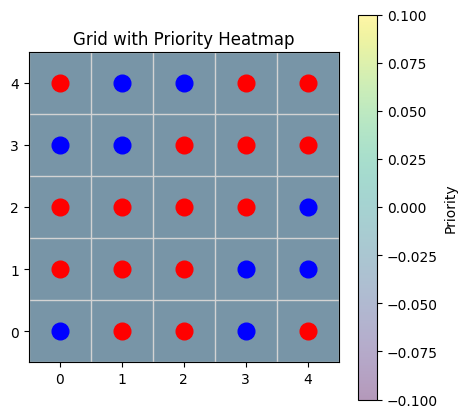

In [6]:
print(f"Playing a complete game with {MCTS_VARIANT} MCTS...\n")

# Reset environment
env.reset()
game_state = unified_env.get_initial_state()
move_count = 0
start_time = time.time()

# Store game history for visualization
game_history = []

while True:
    # Get valid moves
    valid_moves = unified_env.get_valid_moves(game_state)
    value, is_terminal = unified_env.get_value_and_terminated(game_state, valid_moves)
    
    if is_terminal:
        break
    
    # Run MCTS to get action probabilities
    print(f"Move {move_count + 1}: Running MCTS ({MCTS_CONFIG['num_searches']} simulations)...")
    move_start = time.time()
    action_probs = mcts.search(game_state.copy())
    move_time = time.time() - move_start
    
    # Select best action
    action = np.argmax(action_probs)
    row, col = action // GRID_SIZE, action % GRID_SIZE
    
    print(f"  Selected action: ({row}, {col}) [prob: {action_probs[action]:.3f}, time: {move_time:.2f}s]")
    
    # Apply action to both environments
    game_state = unified_env.get_next_state(game_state, action)
    env.self_play_add_point(Point(row, col))
    
    # Store for history
    game_history.append((row, col, action_probs[action], move_time))
    move_count += 1
    
    # Show current state
    print(f"  Current state (after {move_count} moves):")
    env.plot()
    print()

total_time = time.time() - start_time
final_points = np.sum(game_state)

print(f"Game completed!")
print(f"Final result: {final_points} points in {move_count} moves")
print(f"Total time: {total_time:.2f} seconds")
print(f"Average time per move: {total_time/move_count:.2f} seconds")

# Show final visualization
print("\nFinal game state:")
env.plot()

## Game Analysis

Analyze the game that was just played:

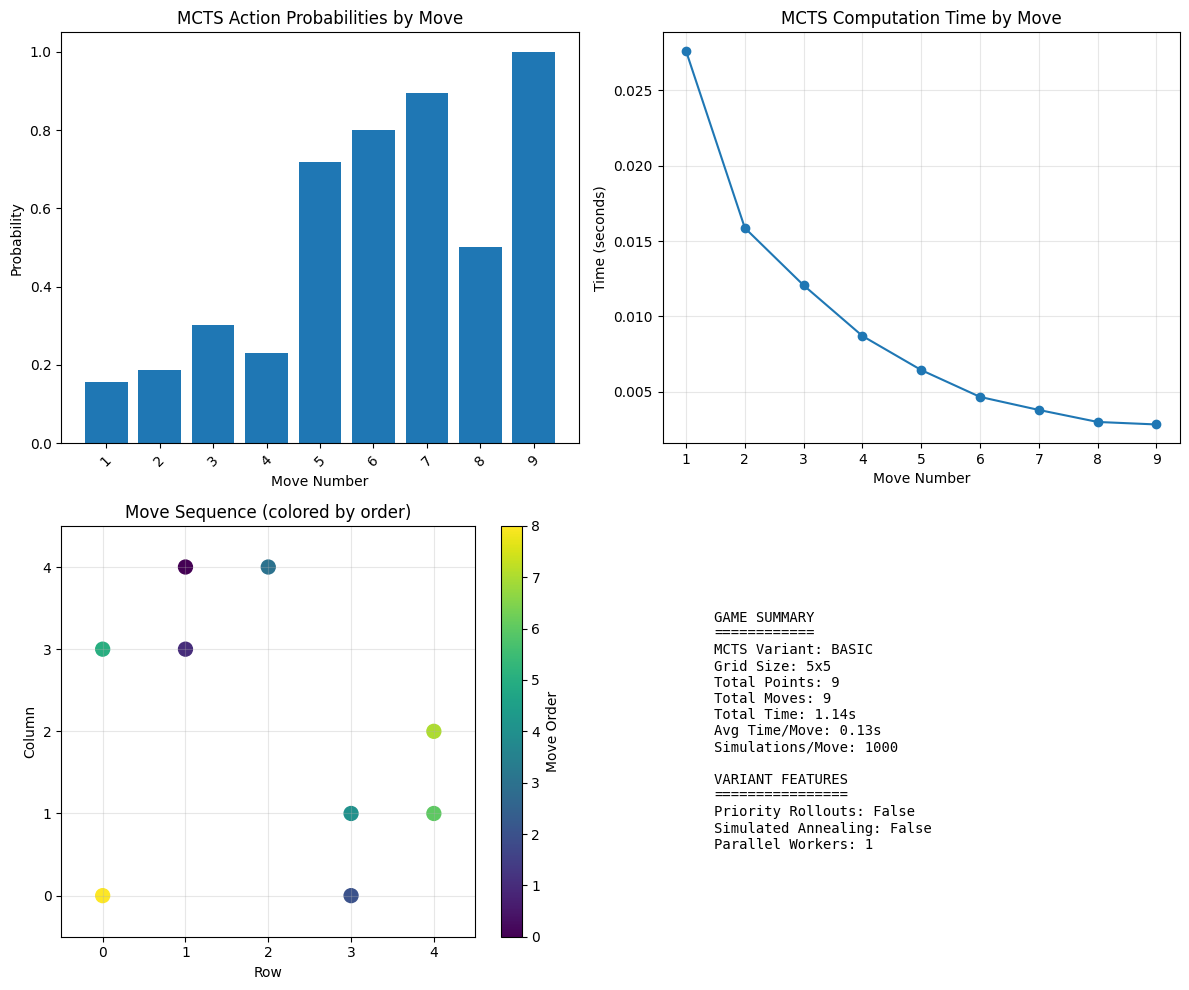


Move Details:
  Move 1: (1,4) - prob: 0.155, time: 0.03s
  Move 2: (1,3) - prob: 0.186, time: 0.02s
  Move 3: (3,0) - prob: 0.302, time: 0.01s
  Move 4: (2,4) - prob: 0.231, time: 0.01s
  Move 5: (3,1) - prob: 0.718, time: 0.01s
  Move 6: (0,3) - prob: 0.801, time: 0.00s
  Move 7: (4,1) - prob: 0.896, time: 0.00s
  Move 8: (4,2) - prob: 0.502, time: 0.00s
  Move 9: (0,0) - prob: 1.000, time: 0.00s


In [7]:
# Create analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Move sequence with probabilities
moves = [f"({h[0]},{h[1]})" for h in game_history]
probs = [h[2] for h in game_history]
ax1.bar(range(len(moves)), probs)
ax1.set_title('MCTS Action Probabilities by Move')
ax1.set_xlabel('Move Number')
ax1.set_ylabel('Probability')
ax1.set_xticks(range(len(moves)))
ax1.set_xticklabels([f"{i+1}" for i in range(len(moves))], rotation=45)

# Plot 2: Computation time per move
times = [h[3] for h in game_history]
ax2.plot(range(1, len(times) + 1), times, 'o-')
ax2.set_title('MCTS Computation Time by Move')
ax2.set_xlabel('Move Number')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True, alpha=0.3)

# Plot 3: Move coordinates visualization
x_coords = [h[0] for h in game_history]
y_coords = [h[1] for h in game_history]
colors = plt.cm.viridis(np.linspace(0, 1, len(game_history)))
scatter = ax3.scatter(x_coords, y_coords, c=range(len(game_history)), cmap='viridis', s=100)
ax3.set_title('Move Sequence (colored by order)')
ax3.set_xlabel('Row')
ax3.set_ylabel('Column')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-0.5, GRID_SIZE - 0.5)
ax3.set_ylim(-0.5, GRID_SIZE - 0.5)
plt.colorbar(scatter, ax=ax3, label='Move Order')

# Plot 4: Performance summary
ax4.axis('off')
summary_text = f"""
GAME SUMMARY
============
MCTS Variant: {MCTS_VARIANT.upper()}
Grid Size: {GRID_SIZE}x{GRID_SIZE}
Total Points: {final_points}
Total Moves: {move_count}
Total Time: {total_time:.2f}s
Avg Time/Move: {total_time/move_count:.2f}s
Simulations/Move: {MCTS_CONFIG['num_searches']}

VARIANT FEATURES
================
Priority Rollouts: {mcts.args.get('simulate_with_priority', False)}
Simulated Annealing: {mcts.args.get('use_annealing', False)}
Parallel Workers: {mcts.args.get('num_workers', 1)}
"""
ax4.text(0.1, 0.5, summary_text, fontsize=10, fontfamily='monospace', 
         verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

print(f"\nMove Details:")
for i, (row, col, prob, time_taken) in enumerate(game_history):
    print(f"  Move {i+1}: ({row},{col}) - prob: {prob:.3f}, time: {time_taken:.2f}s")

## MCTS Variant Comparison

Compare all four MCTS variants on the same environment:

Comparing all MCTS variants...

Testing basic MCTS...
  Result: 10 points in 0.02s
Testing priority MCTS...
  Result: 9 points in 0.02s
Testing parallel MCTS...
  Result: 10 points in 0.02s
Testing advanced MCTS...
  Result: 10 points in 0.02s

Comparison Results:
✓ basic   : 10 points in  0.02s
✓ priority:  9 points in  0.02s
✓ parallel: 10 points in  0.02s
✓ advanced: 10 points in  0.02s


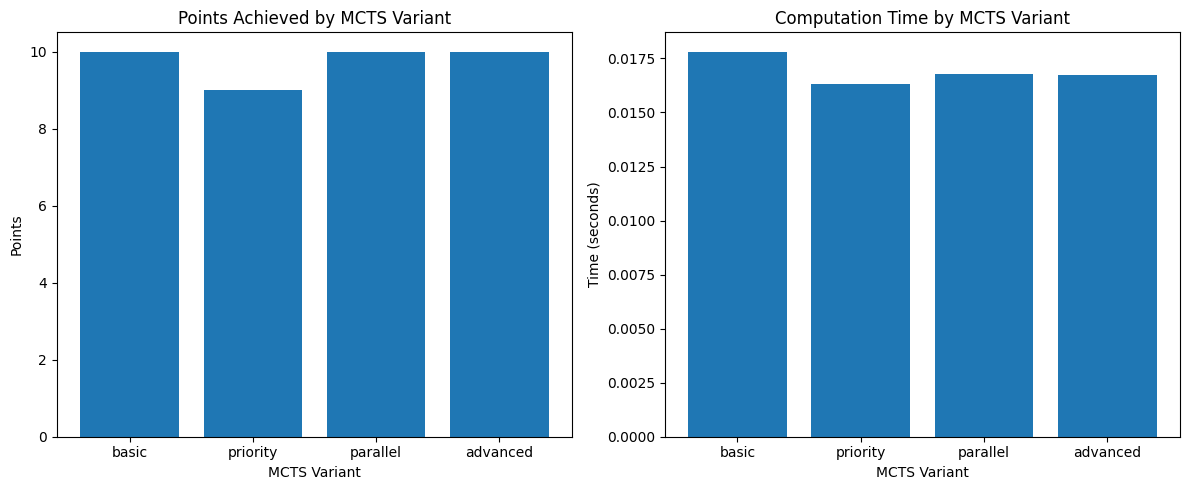

In [9]:
print("Comparing all MCTS variants...\n")

variants = ['basic', 'priority', 'parallel', 'advanced']
comparison_results = {}

# Reduced simulations for comparison speed
comparison_config = MCTS_CONFIG.copy()
comparison_config['num_searches'] = 200  # Faster comparison
comparison_config['display_state'] = False  # No intermediate plots
comparison_config['logging_mode'] = True  # Enable return of actual points

for variant in variants:
    print(f"Testing {variant} MCTS...")
    start_time = time.time()
    
    try:
        # Run evaluation
        points = evaluate_unified(comparison_config, variant=variant)
        total_time = time.time() - start_time
        
        comparison_results[variant] = {
            'points': points if points is not None else 0,
            'time': total_time,
            'success': True
        }
        print(f"  Result: {comparison_results[variant]['points']} points in {total_time:.2f}s")
        
    except Exception as e:
        print(f"  Error: {e}")
        comparison_results[variant] = {
            'points': 0,
            'time': 0,
            'success': False
        }

print("\nComparison Results:")
print("====================")
for variant, result in comparison_results.items():
    status = "✓" if result['success'] else "✗"
    print(f"{status} {variant:8}: {result['points']:2} points in {result['time']:5.2f}s")

# Visualization of comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Points comparison
successful_variants = [v for v in variants if comparison_results[v]['success']]
points = [comparison_results[v]['points'] for v in successful_variants]
times = [comparison_results[v]['time'] for v in successful_variants]

if successful_variants:
    ax1.bar(successful_variants, points)
    ax1.set_title('Points Achieved by MCTS Variant')
    ax1.set_ylabel('Points')
    ax1.set_xlabel('MCTS Variant')
    
    ax2.bar(successful_variants, times)
    ax2.set_title('Computation Time by MCTS Variant')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xlabel('MCTS Variant')
else:
    ax1.text(0.5, 0.5, 'No successful runs', ha='center', va='center')
    ax2.text(0.5, 0.5, 'No successful runs', ha='center', va='center')

plt.tight_layout()
plt.show()

## Interactive Experimentation

Change the configuration above and re-run cells to experiment with different settings!

### Try these experiments:

1. **Grid Size Effects**: Change `GRID_SIZE` to 3, 4, 6, or 7 and see how performance scales

2. **MCTS Variants**: Switch `MCTS_VARIANT` between:
   - `"basic"`: Standard MCTS
   - `"priority"`: With priority-guided rollouts
   - `"parallel"`: Multi-threaded search
   - `"advanced"`: All features combined

3. **Hyperparameter Tuning**:
   - `num_searches`: More simulations = better play but slower
   - `C`: Higher values = more exploration
   - `top_n`: For priority variants, try 1, 2, or 3
   - `num_workers`: For parallel variants, try 2, 4, or 8

4. **Priority Functions**: Modify the `priority_function` to prefer different regions

### Quick Reset and Re-run:
To try a new configuration:
1. Modify the configuration in the "Configuration" cell
2. Run all cells from "Configuration" onwards
3. Compare results!

# Comprehensive Method Comparison

Let's compare all available methods (Greedy Search + 4 MCTS variants) on the 60x60 grid:

In [10]:
# Comprehensive comparison of all methods
print("🔄 Running comprehensive comparison on 60x60 grid...")
print("This may take several minutes to complete.\n")

# Storage for all results
all_results = {}
all_timings = {}

# Test 1: Greedy Search using environment
print("1️⃣ Testing Greedy Search...")
env_60 = get_env(ENV_NAME)(60, 60)
start_time = time.time()
greedy_result = env_60.greedy_search()
greedy_time = time.time() - start_time
all_results['Greedy Search'] = greedy_result
all_timings['Greedy Search'] = greedy_time
print(f"   ✅ Greedy Search: {greedy_result} points in {greedy_time:.2f}s")

# Test 2-5: All MCTS variants
mcts_variants = ['basic', 'priority', 'parallel', 'advanced']
comparison_config = {
    'n': 60,
    'num_searches': 500,  # Reduced for faster execution
    'C': 1.414,
    'top_n': 2,
    'num_workers': 4,
    'virtual_loss': 1.0,
    'priority_type': 'supnorm',
    'display_state': False,
    'process_bar': False,
    'logging_mode': True  # Ensure results are returned
}

for i, variant in enumerate(mcts_variants, 2):
    print(f"{i}️⃣ Testing MCTS {variant}...")
    try:
        start_time = time.time()
        mcts_result = evaluate_unified(comparison_config, variant=variant)
        mcts_time = time.time() - start_time
        
        all_results[f'MCTS {variant}'] = mcts_result
        all_timings[f'MCTS {variant}'] = mcts_time
        print(f"   ✅ MCTS {variant}: {mcts_result} points in {mcts_time:.2f}s")
        
    except Exception as e:
        print(f"   ❌ MCTS {variant} failed: {e}")
        all_results[f'MCTS {variant}'] = 0
        all_timings[f'MCTS {variant}'] = 0

print("\n✅ Comprehensive comparison completed!")

🔄 Running comprehensive comparison on 60x60 grid...
This may take several minutes to complete.

1️⃣ Testing Greedy Search...
   ✅ Greedy Search: 89 points in 0.53s
2️⃣ Testing MCTS basic...
   ✅ MCTS basic: 90 points in 43.43s
3️⃣ Testing MCTS priority...
   ✅ MCTS priority: 87 points in 28.74s
4️⃣ Testing MCTS parallel...
   ✅ MCTS parallel: 90 points in 43.59s
5️⃣ Testing MCTS advanced...
   ✅ MCTS advanced: 90 points in 36.51s

✅ Comprehensive comparison completed!


🏆 COMPREHENSIVE RESULTS SUMMARY - 60x60 GRID
Method               Points Found    Time (seconds)  Points/Second  
----------------------------------------------------------------------
Greedy Search        89              0.53            168.65         
MCTS basic           90              43.43           2.07           
MCTS priority        87              28.74           3.03           
MCTS parallel        90              43.59           2.06           
MCTS advanced        90              36.51           2.47           


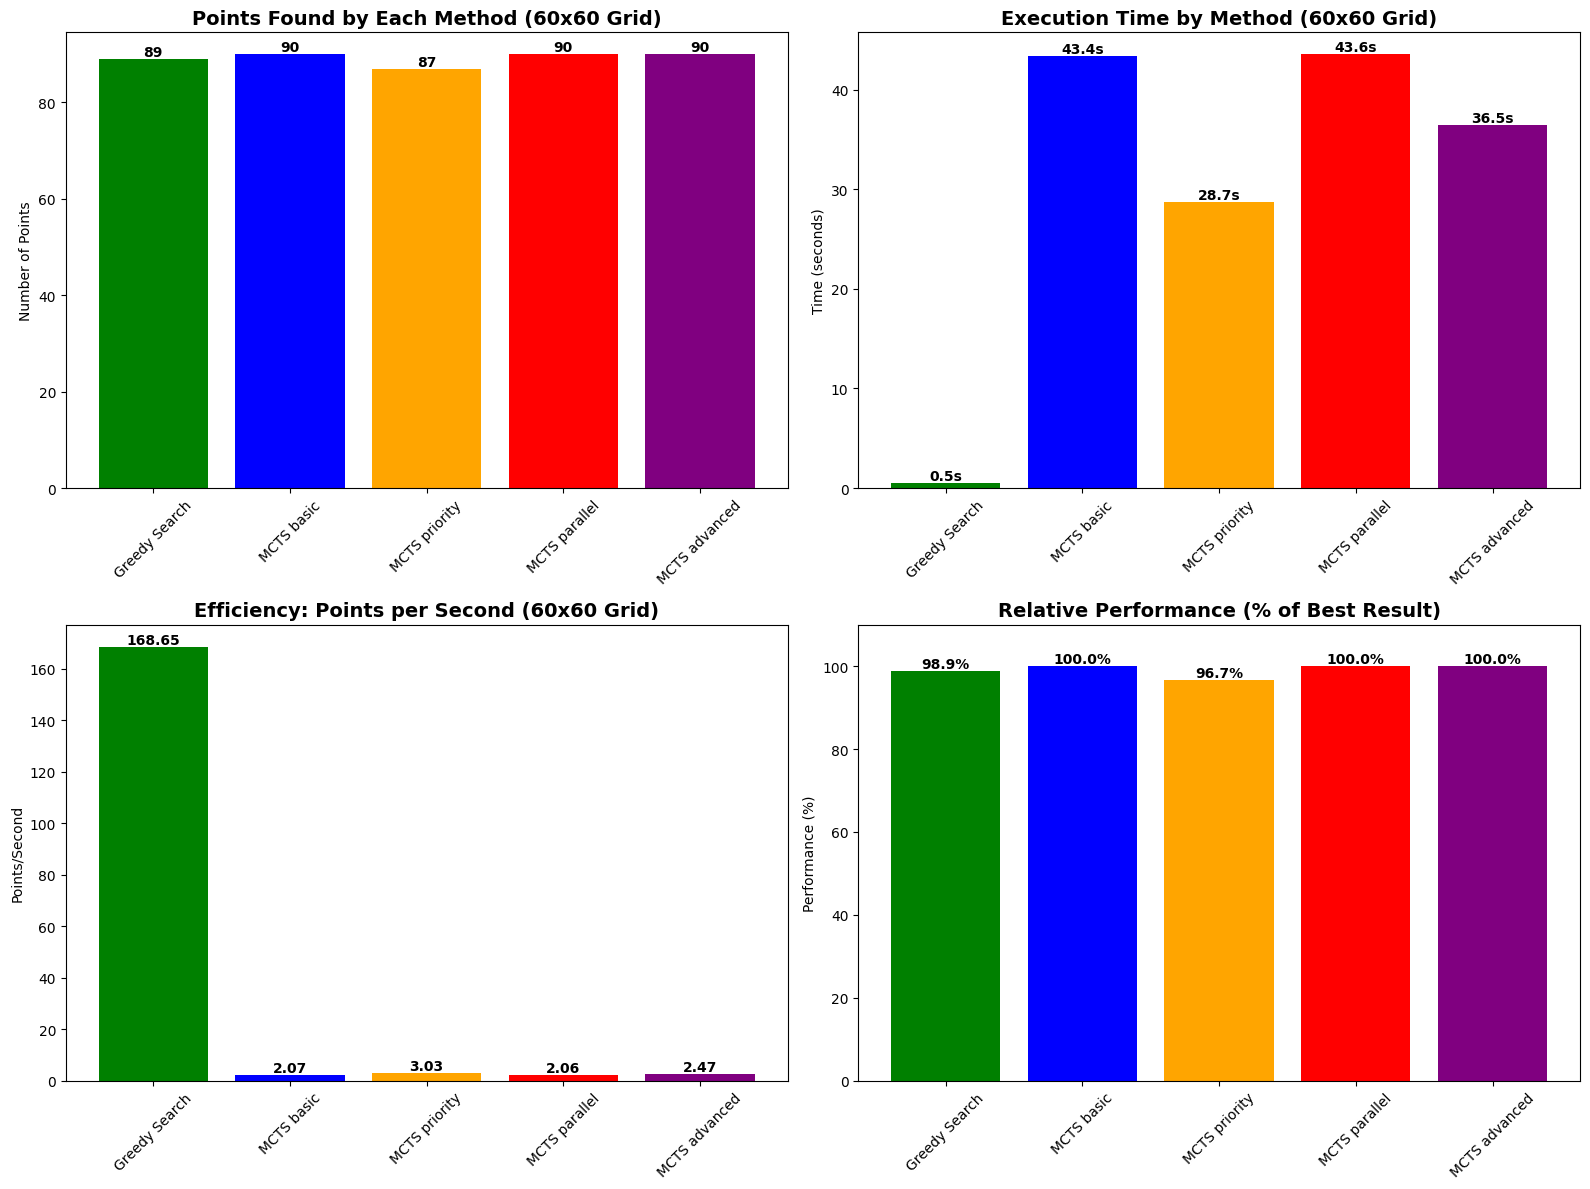


📊 KEY INSIGHTS:
🏆 Best Performance: MCTS basic with 90 points
⚡ Fastest Method: Greedy Search in 0.53 seconds
🎯 Most Efficient: Greedy Search (168.65 points/second)
📈 Performance Range: 87 - 90 points
⏱️ Time Range: 0.53 - 43.59 seconds


In [11]:
# Results Visualization and Analysis
print("=" * 80)
print("🏆 COMPREHENSIVE RESULTS SUMMARY - 60x60 GRID")
print("=" * 80)

# Create summary table
print(f"{'Method':<20} {'Points Found':<15} {'Time (seconds)':<15} {'Points/Second':<15}")
print("-" * 70)

for method in all_results:
    points = all_results[method]
    time_taken = all_timings[method]
    efficiency = points / time_taken if time_taken > 0 else 0
    print(f"{method:<20} {points:<15} {time_taken:<15.2f} {efficiency:<15.2f}")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

methods = list(all_results.keys())
points_found = list(all_results.values())
times = list(all_timings.values())
colors = ['green', 'blue', 'orange', 'red', 'purple']

# Plot 1: Points found comparison
bars1 = ax1.bar(methods, points_found, color=colors[:len(methods)])
ax1.set_title('Points Found by Each Method (60x60 Grid)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Points')
ax1.tick_params(axis='x', rotation=45)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', 
             ha='center', va='bottom', fontweight='bold')

# Plot 2: Execution time comparison
bars2 = ax2.bar(methods, times, color=colors[:len(methods)])
ax2.set_title('Execution Time by Method (60x60 Grid)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Time (seconds)')
ax2.tick_params(axis='x', rotation=45)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}s', 
             ha='center', va='bottom', fontweight='bold')

# Plot 3: Efficiency (Points per second)
efficiency = [points_found[i] / times[i] if times[i] > 0 else 0 for i in range(len(methods))]
bars3 = ax3.bar(methods, efficiency, color=colors[:len(methods)])
ax3.set_title('Efficiency: Points per Second (60x60 Grid)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Points/Second')
ax3.tick_params(axis='x', rotation=45)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', 
             ha='center', va='bottom', fontweight='bold')

# Plot 4: Comparative performance chart
relative_performance = [p / max(points_found) * 100 for p in points_found]
bars4 = ax4.bar(methods, relative_performance, color=colors[:len(methods)])
ax4.set_title('Relative Performance (% of Best Result)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Performance (%)')
ax4.set_ylim(0, 110)
ax4.tick_params(axis='x', rotation=45)
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
best_method = max(all_results, key=all_results.get)
fastest_method = min(all_timings, key=all_timings.get)
most_efficient = max(methods, key=lambda m: all_results[m] / all_timings[m] if all_timings[m] > 0 else 0)

print("\n" + "=" * 80)
print("📊 KEY INSIGHTS:")
print("=" * 80)
print(f"🏆 Best Performance: {best_method} with {all_results[best_method]} points")
print(f"⚡ Fastest Method: {fastest_method} in {all_timings[fastest_method]:.2f} seconds")
print(f"🎯 Most Efficient: {most_efficient} ({all_results[most_efficient] / all_timings[most_efficient]:.2f} points/second)")
print(f"📈 Performance Range: {min(all_results.values())} - {max(all_results.values())} points")
print(f"⏱️ Time Range: {min(all_timings.values()):.2f} - {max(all_timings.values()):.2f} seconds")

## Conclusion

This notebook demonstrates the unified MCTS framework that integrates all four advanced variants:

- **Modularity**: Easy switching between variants and environments
- **Performance**: Optimized implementations with Numba acceleration
- **Visualization**: Rich plotting using the environment's built-in plot functions
- **Analysis**: Comprehensive game analysis and variant comparison

The system provides a "one-click" interface for experimenting with different MCTS approaches on the No-Three-Collinear problem, making it easy to:
- Test algorithmic improvements
- Analyze game strategies
- Compare performance across variants
- Visualize results and game progression

All variants use the same underlying unified implementation, ensuring consistency and reliability across experiments.